In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ładowanie kontekstu dla nowszych wersji Kedro (z pominięciem package_name)
from kedro.framework.session import KedroSession
from pathlib import Path
import logging

# Ustawienie loggera, aby widzieć komunikaty Kedro
logger = logging.getLogger(__name__)

PROJECT_PATH = Path.cwd().parent 

# Uruchomienie ładowania kontekstu
with KedroSession.create(
    project_path=PROJECT_PATH
) as session:
    
    context = session.load_context()
    catalog = context.catalog
    logger.info("Kontekst Kedro załadowany pomyślnie.")
    
    try:
        data_raw = catalog.load("processed_data")

        print("Pierwsze 5 wierszy wczytanego zbioru danych:")
        print(data_raw.head())
        print("-" * 50)
        print(f"Kształt wczytanego zbioru danych: {data_raw.shape}")

    except Exception as e:
        print(f"Szczegóły błędu: {e}")


[11/06/25 21:17:17] INFO     Kedro is sending anonymous usage data with the sole purpose of improving plugin.py:243
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[11/06/25 21:17:19] INFO     Loading data from processed_data (CSVDataset)...                  data_catalog.py:1046

Pierwsze 5 wierszy wczytanego zbioru danych:
              Outcome Date  Animal ID    Name   Outcome Status  \
0  2025 Jun 22 06:12:03 PM       8747   Smoke          Adopted   
1  2025 Jun 07 06:12:00 PM       9225   Boxer     Transfer Out   
2  2025 Jun 30 11:17:00 AM       8588  Smidge  Adopted Altered   
3  2025 Jun 11 02:31:24 PM       6490     NaN  Adopted Altered   
4  2025 Jun 13 09:20:00 AM       7812     NaN     Transfer Out   

  Euthanasia Reason Type     Sex Spayed/Neutered  \
0               NaN  Dog    Male             Yes   
1               NaN  Dog    Male         Unknown   
2               NaN  Cat  Female             Yes   
3               NaN  Cat    Male             Yes   
4               NaN  Dog  Female              No   

                    Primary Breed Primary Color Secondary Color  \
0       American Pit Bull Terrier     Chocolate             NaN   
1                       Coonhound          Rust           White   
2              Domestic Shorthair   Brown Ta

In [27]:
print("Typy danych kolumn:\n", data_raw.dtypes)
print("\nStatystyki opisowe dla zmiennych numerycznych:\n", data_raw.describe().T)

# 2. Analiza braków danych
missing_info = data_raw.isnull().sum()
missing_percent = (missing_info / len(data_raw)) * 100

missing_data_summary = pd.DataFrame({
    'Brakujące Wartości': missing_info,
    'Procent Braków': missing_percent.round(2)
})

print("\nAnaliza braków danych (tylko kolumny z brakami):\n")
print(missing_data_summary[missing_data_summary['Procent Braków'] > 0].sort_values(by='Procent Braków', ascending=False))

Typy danych kolumn:
 Outcome Date          object
Animal ID              int64
Name                  object
Outcome Status        object
Euthanasia Reason     object
Type                  object
Sex                   object
Spayed/Neutered       object
Primary Breed         object
Primary Color         object
Secondary Color       object
Date of Birth         object
Intake Date           object
Days in Shelter      float64
is_adopted             int64
dtype: object

Statystyki opisowe dla zmiennych numerycznych:
                   count          mean          std     min      25%      50%  \
Animal ID        6690.0  11138.947833  3425.289746  5944.0  7983.25  11009.0   
Days in Shelter  6686.0     31.316183    56.181024     0.0     4.00     12.0   
is_adopted       6690.0      0.567414     0.495472     0.0     0.00      1.0   

                      75%      max  
Animal ID        14020.75  17727.0  
Days in Shelter     39.00    959.0  
is_adopted           1.00      1.0  

Analiza bra

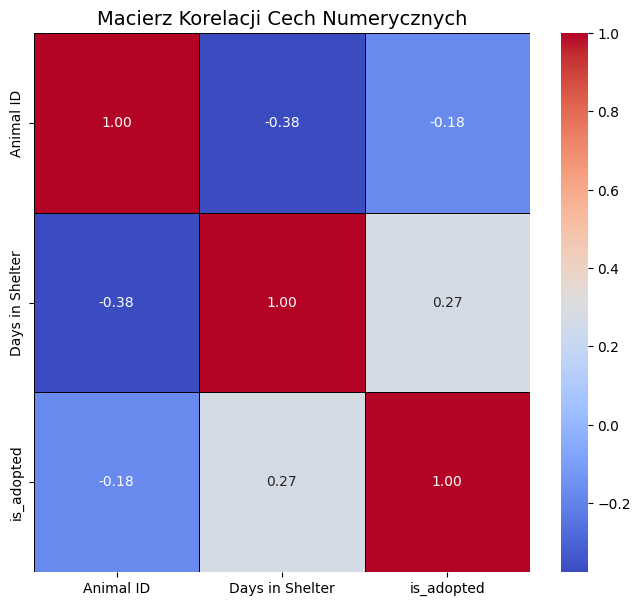

In [16]:
# Wizualizacja Macierzy Korelacji
# Zwykle tylko kolumny numeryczne mają sens w tym kontekście
numeric_data = data_raw.select_dtypes(include=[np.number])

# Jeśli Days in Shelter to jedyna kolumna numeryczna, heatmapa będzie bezużyteczna, 
# ale standardowo to jest dobry krok:
if numeric_data.shape[1] > 1:
    correlation_matrix = numeric_data.corr()

    plt.figure(figsize=(8, 7))
    sns.heatmap(
        correlation_matrix,
        annot=True,        
        cmap='coolwarm',   
        fmt=".2f",         
        linewidths=.5,     
        linecolor='black'
    )
    plt.title('Macierz Korelacji Cech Numerycznych', fontsize=14)
    plt.show()
else:
    print("Brak wystarczającej liczby kolumn numerycznych do stworzenia sensownej macierzy korelacji.")

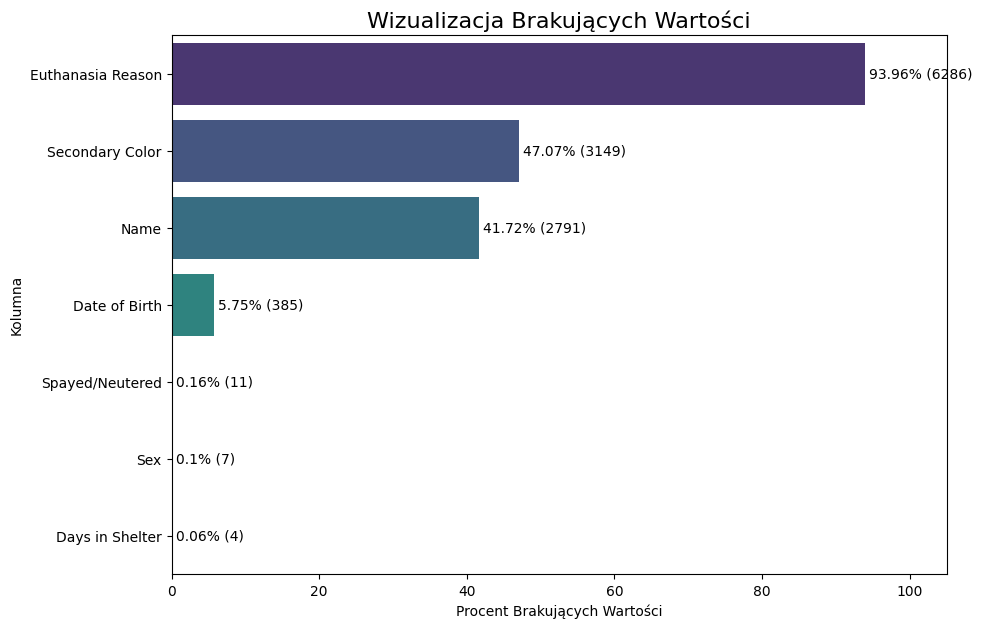

In [31]:
df_analiza = data_raw.copy() 

df_missing = df_analiza.isnull().sum()
df_missing = df_missing[df_missing > 0].sort_values(ascending=False)
df_missing_percent = (df_missing / len(df_analiza)) * 100

missing_data_plot = pd.DataFrame({
    'Brakujące Wartości': df_missing,
    'Procent Braków': df_missing_percent.round(2)
})
missing_data_plot = missing_data_plot.reset_index().rename(columns={'index': 'Kolumna'})

plt.figure(figsize=(10, 7))
sns.barplot(
    data=missing_data_plot, 
    x='Procent Braków', 
    y='Kolumna', 
    hue='Kolumna',      
    palette='viridis',
    legend=False        
)

for index, row in missing_data_plot.iterrows():
    plt.text(
        row['Procent Braków'] + 0.5, 
        index, 
        f"{row['Procent Braków']}% ({row['Brakujące Wartości']})", 
        color='black', 
        ha="left", 
        va="center"
    )

plt.title('Wizualizacja Brakujących Wartości', fontsize=16)
plt.xlabel('Procent Brakujących Wartości')
plt.ylabel('Kolumna')
plt.xlim(0, 105) 
plt.show()

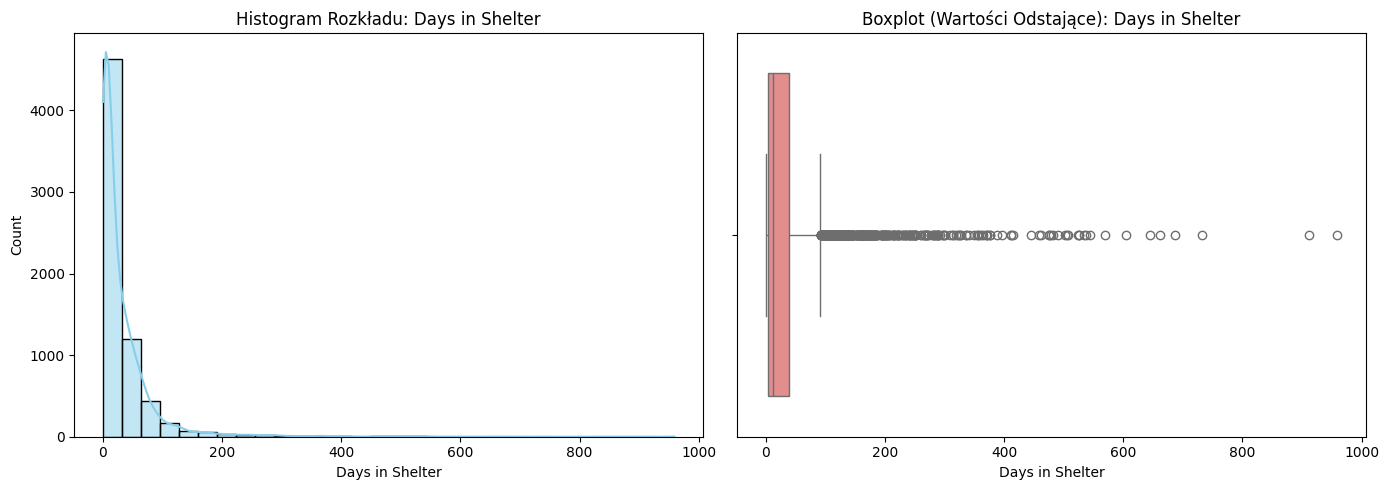

In [33]:
numeric_cols = ['Days in Shelter'] 

for col in numeric_cols:
    if col in df_analiza.columns and df_analiza[col].dtype in ['float64', 'Int64']:
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        sns.histplot(
            df_analiza[col].dropna(), 
            kde=True, 
            ax=axes[0], 
            bins=30, 
            color='skyblue'
        )
        axes[0].set_title(f'Histogram Rozkładu: {col}')
        
        sns.boxplot(
            x=df_analiza[col].dropna(), 
            ax=axes[1], 
            color='lightcoral'
        )
        axes[1].set_title(f'Boxplot (Wartości Odstające): {col}')
        
        plt.tight_layout()
        plt.show()
    elif col not in df_analiza.columns:
         print(f"Ostrzeżenie: Kolumna '{col}' nie istnieje w danych.")
    else:
        print(f"Ostrzeżenie: Kolumna '{col}' ma typ {df_analiza[col].dtype} i nie jest numeryczna.")

--- Countploty dla Zmiennych Kategorycznych (PIONOWE) ---


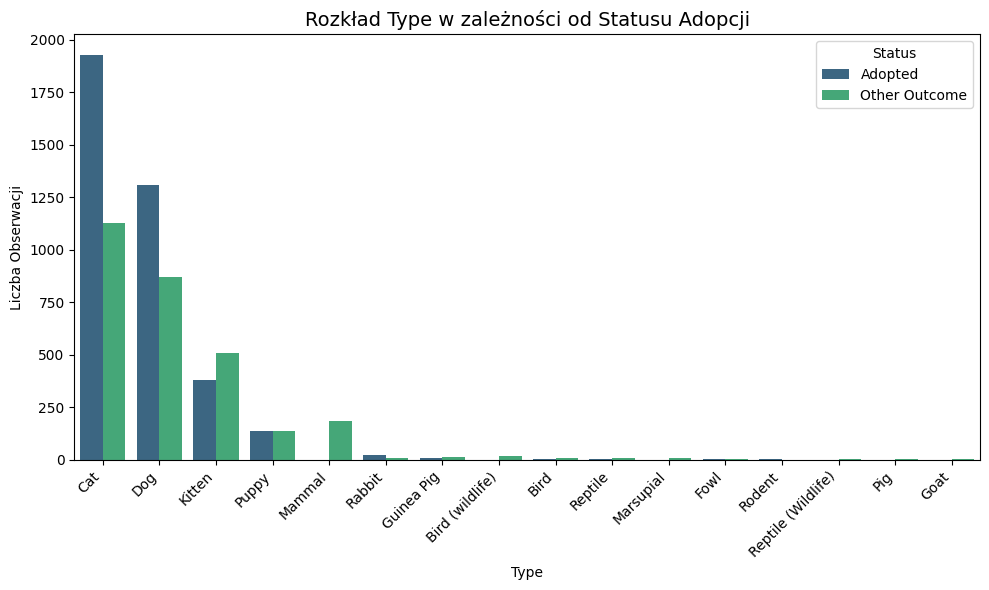

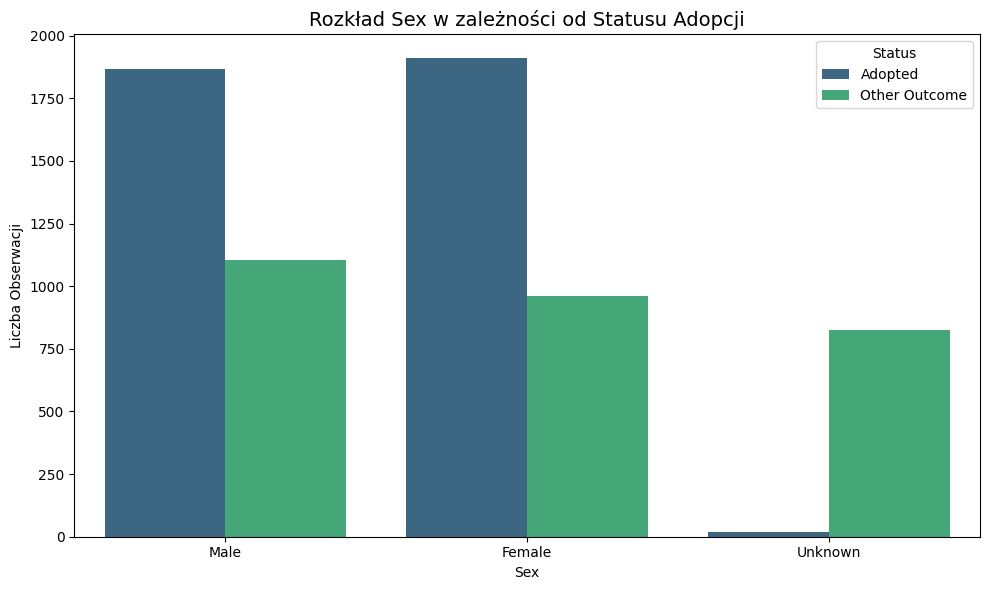

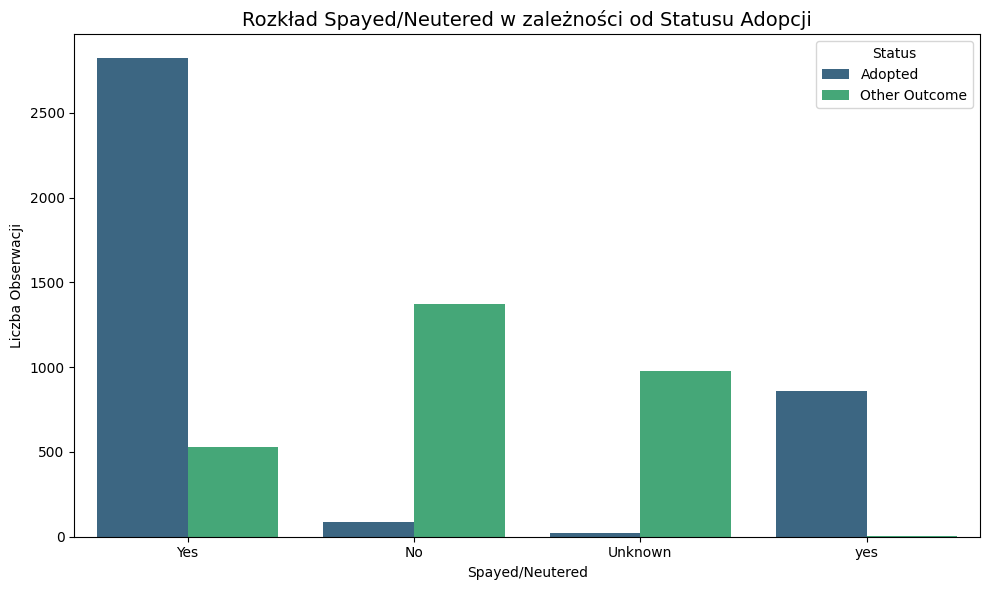

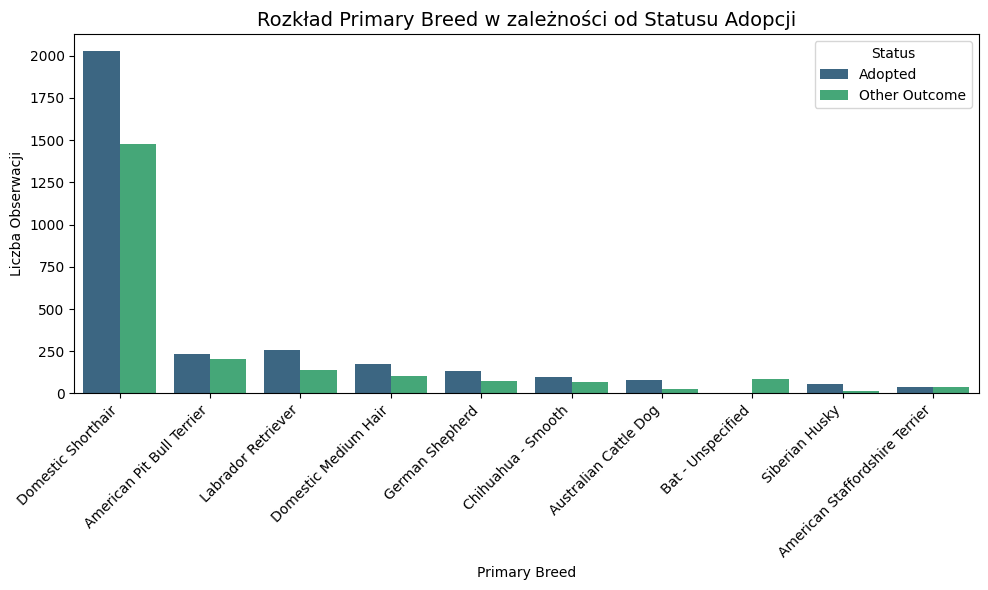

In [36]:
categorical_cols = ['Type', 'Sex', 'Spayed/Neutered', 'Primary Breed']

if 'Is Adopted Label' not in df_analiza.columns:
    df_analiza['Is Adopted Label'] = df_analiza['is_adopted'].map({1: 'Adopted', 0: 'Other Outcome'})

print("--- Countploty dla Zmiennych Kategorycznych (PIONOWE) ---")

for col in categorical_cols:
    if col in df_analiza.columns:
        plt.figure(figsize=(10, 6)) 
        
        if col == 'Primary Breed':
            top_counts = df_analiza[col].value_counts().nlargest(10).index
            data_to_plot = df_analiza[df_analiza[col].isin(top_counts)]
            order_list = top_counts
        else:
            data_to_plot = df_analiza
            order_list = df_analiza[col].value_counts().index
            

        sns.countplot(
            data=data_to_plot,
            x=col,                       
            hue='Is Adopted Label',
            order=order_list,
            palette='viridis'
        )
            
        plt.title(f'Rozkład {col} w zależności od Statusu Adopcji', fontsize=14)
        plt.xlabel(col)
        plt.ylabel('Liczba Obserwacji')
        plt.legend(title='Status')
        

        if len(order_list) > 5:
            plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Ostrzeżenie: Kolumna '{col}' nie istnieje w DataFrame.")